# Choosing feedback parameters

---
## Finding parameters

This notebook illustrates how analytical solutions of idealized float displacements may guide the choice of the parameters employed in the state feedback regulation algorithm. These parameters consist of three parameters: an inverse time scale $r$, a velocity $\nu$, and a length scale $\delta$ (see this [notebook](https://github.com/houdeval/cognac_regulation/blob/master/feedback_model_description.ipynb) for details about the implementation)


Thanks to a simplified simulation, $r$ will be deduced so as to compute $\lambda_1$ and $\lambda_2$ which are relaxation parameters. Similarly, the characteristic length of the regulation $\delta$ and the characteristic velocity $\nu$ will be estimated so as to use their value in the command law.


The estimation of the parameters will be based on a basic dynamical model in which we assume that the float is only subjected to its weight and its Archimedean buoyant force.


From this model, 4 functions have been implemented :

$v_f$ computing the velocity of the float as a function of time and $z_f$ computing the position of the float as a function of time :


$$
\begin{align}
v_f (t) &= \frac{\rho_w u ~g t^{2}}{2 m (1+a)} \\
z_f (t) &= \frac{\rho_w u ~g t^{3}}{6 m (1+a)}
\end{align}
$$


To assess the time and distance parameters $r$ and $\delta$, it will be useful to create a function $t_\nu$ computing the necessary time for the float to reach a given speed $\nu$ and another function $z_\nu$ computing the necessary depth for the float to reach the same given speed $\nu$ :


$$
\begin{align}
t_\nu (\nu) &= \sqrt{\frac{2 m (1+a) \nu}{\rho_w u ~g}} \\
z_\nu (\nu) &= z_f(t_\nu(\nu)) &= \frac{\rho_w u ~g (\sqrt{\frac{2 m (1+a) \nu}{\rho_w u ~g}})^{3}}{6 m (1+a)}
\end{align}
$$


$g$ acceleration of gravity (m/s$^2$)

$v_f$ downward velocity (m/s)

$m$ float mass (kg)

$a$ float added mass (no dimension)

$\rho_w$ water density (kg/m$^3$)

$u$ piston volume rate of change (the piston is supposed to leave the cylinder of the float with a constant velocity $u$) (m$^3$/s)


### Estimation of $\nu$

Let's choose first the velocity parameter $\nu$ that corresponds to the typical vertical velocity the float should move at to perform a correct regulation.

This velocity is limited by two phenomena : 

-On the one hand because of drag, the float cannot move above a certain speed.

-On the other hand, a too high speed can beget oscillations when arriving around target depths.

Thus overall, $\nu*\pi/2$ must correspond to the lower speed among both of these.

For example, for ENSTA float, the following graphs show the depth response as a function of time for different regulation speeds : 0.04 m/s, 0.10 m/s, 0.15 m/s and the corresponding velocity as a function of time.

![Depth response as a function of time for different regulation speeds : 0.04 m/s, 0.10 m/s, 0.15 m/s](images_feedback_parameters/different_speed_graph.png)

![Velocity as a function of time for different regulation speeds : 0.04 m/s, 0.10 m/s, 0.15 m/s](images_feedback_parameters/velocity.png)

From these graphs, it can be deduced that the maximal velocity allowing to avoid oscillations and possibly reachable is between 0.10 m/s and 0.15 m/s. Let's choose 0.10 m/s for $\nu*\pi/2$.


### Estimation of $\delta$

$\delta$ is a length scale that defines the zone of influence around the target depth.

That is to say mathematically :

The velocity $x_1\xrightarrow{}0$ when the position error $|x_2-\overline{x}_2|<\delta$

In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

Text(1, 1, '2 x delta')

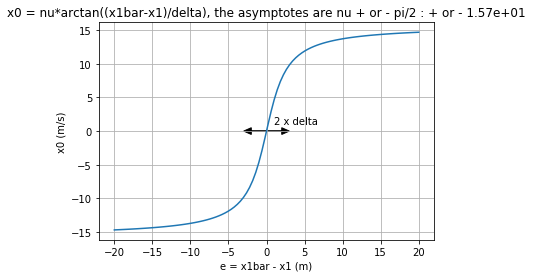

In [2]:
def x_0(e,nu,delta):
    # e is x1bar - x1
    return nu * np.arctan(e/delta)


e = np.linspace(-20,20,100)
nu = 10
delta = 2
fig, ax = plt.subplots()
ax.plot(e, x_0(e,nu,delta))
ax.set_xlabel('e = x1bar - x1 (m)')
ax.set_ylabel('x0 (m/s)')
ax.set_title('x0 = nu*arctan((x1bar-x1)/delta), the asymptotes are nu + or - pi/2 : + or - {:.2e}'.format(nu*np.pi/2))
ax.grid()
ax.arrow(0,0,delta,0,head_width=1, head_length=1, fc='k', ec='k', label = 'delta')
ax.arrow(0,0,-delta,0,head_width=1, head_length=1, fc='k', ec='k')
ax.text(1,1,"2 x delta")



#on peut choisir un autre type de fonction seuillee (fonction d'activation) 
#pour simplifier les calculs du microcontroleur (sigmoid)

In short, $\delta$ corresponds to the depth traveled by the float before reaching the maximum speed $\nu*\pi/2$ from an equilibrium.
Therefore, to estimate $\delta$, we can use the previous formula which has been defined previously :

$$
\begin{align}
\delta &= z_\nu (\nu\pi/2) &= z_f(t_\nu(\nu\pi/2)) &= \frac{\rho_w u ~g (\sqrt{\frac{2 m (1+a) *\nu\pi/2}{\rho_w u ~g}})^{3}}{6 m (1+a)}
\end{align}
$$

### Estimation of $r$

The control time scale $1/r$ needs to be equal or larger than the time taken for the float to reach the maximum speed $\nu*\pi/2$ from an equilibrium.

Thus, $1/r$ is given by :

$$
\begin{align}
t_\nu (\nu\pi/2) &= \sqrt{\frac{2 m (1+a) *\nu\pi/2}{\rho_w u ~g}} \\
\end{align}
$$


## Definition of the parameters and functions


In [3]:
def zf(t, params):

    '''
    Function computing the float position depending on time and float parameters
    for initial conditions zf = 0 and vf = 0 at the beginning
    '''
    return (params['u']*g*rho_w*t**3) /6 /params['m'] /(1+params['a'])


def vf(t, params):

    '''
    Function computing the float speed depending on time and float parameters
    for initial conditions zf = 0 and vf = 0 at the beginning
    '''
    return (params['u']*g*rho_w*t**2) / (2*params['m']*(1+params['a']))


def tv(v, params):

    '''
    Function computing the time necessary for the float to reach the speed v
    '''
    return np.sqrt(2*v*params['m']*(1+params['a'])/(g*rho_w*params['u']))


def zv(v, params):

    '''
    Function computing the distance necessary for the float to reach the speed v
    '''
    return zf(tv(v,params),params)



In [4]:
def omega2dvdt(omega=12.4*2.*np.pi/60., lead=0.0175, r_piston=0.025):

    '''
    Function computing the piston flow u
    parameters:
        omega: float [rad/s]
            current rotation rate, omega=dphi/dt
            for ENSTA float, omega_max = 124.*2.*np.pi/60.,
            omega_min = 12.4*2.*np.pi/60.
        lead: float [m]
            screw lead (i.e. displacement after one screw revolution)
            d = phi/2/pi x lead
        r_piston: float [m]
            piston radius
    '''
    return omega*lead/2.*r_piston**2


'''
parameters:
    g : gravity acceleration [m.s^-2]
    m : float mass [kg]
    a : float added mass [no dimension]
    r : float radius [m]
    L : float length [m]
    rho_w : water density [kg.m^3]
    omega :  current rotation rate [rad/s]
    lead : screw lead (i.e. displacement after one screw revolution) [m]
    r_piston : piston radius [m]
    u : piston flow [m^3.s^-1]
'''

g = 9.81 #m.s^-2
rho_w = 997 #kg.m^3

params_ensta = {'r': 0.06, 'L': 0.5, 'a': 1., 'omega' : 20/48*2.*np.pi, 'lead' : 0.00175, 'r_piston' : 0.025}
params_ensta['m'] = 9.0 #1000. * np.pi * params_ensta['r'] ** 2 * params_ensta['L']

params_ensta['u'] = omega2dvdt(params_ensta['omega'], params_ensta['lead'], params_ensta['r_piston'])
print(params_ensta)


params_ifremer = {'r': 0.07, 'L': 0.8278, 'a': 1., 'omega' : 20/48*2.*np.pi, 'lead' : 0.001, 'r_piston' : 0.0195/2}
params_ifremer['m'] = 13.315 #1000. * np.pi * params_ifremer['r'] ** 2 * params_ifremer['L']

params_ifremer['u'] = omega2dvdt(params_ifremer['omega'], params_ifremer['lead'], params_ifremer['r_piston'])


{'r': 0.06, 'L': 0.5, 'a': 1.0, 'omega': 2.6179938779914944, 'lead': 0.00175, 'r_piston': 0.025, 'm': 9.0, 'u': 1.431715402026599e-06}


---

## Simulation



---
### Automatic estimation of feedback parameters


---
### For ENSTA float


In [5]:
vmax_reached = 0.07 #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.

nu = (2/np.pi)*vmax_reached

tau = tv(vmax_reached, params_ensta)

r = 1/tau

delta = zv(vmax_reached, params_ensta)

print('maximale velocity assumed = {}m/s, nu = {}m/s, tau = {}s, r = 1/tau = {}s^-1, delta = {}m'.format(vmax_reached, nu, tau, r,delta))


maximale velocity assumed = 0.07m/s, nu = 0.0445633840657307m/s, tau = 13.414974115837028s, r = 1/tau = 0.0745435653744163s^-1, delta = 0.31301606270286403m


---
### For IFREMER float


In [6]:
vmax_reached = 0.10 #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.

nu = (2/np.pi)*vmax_reached

tau = tv(vmax_reached, params_ifremer)

r = 1/tau

delta = zv(vmax_reached, params_ifremer)

print('maximale velocity assumed = {}m/s, nu = {}m/s, tau = {}s, r = 1/tau = {}s^-1, delta = {}m'.format(vmax_reached, nu, tau, r,delta))


maximale velocity assumed = 0.1m/s, nu = 0.06366197723675814m/s, tau = 66.1522418999259s, r = 1/tau = 0.015116645653714726s^-1, delta = 2.20507472999753m
